# Crispening Effect

The idea is to generate a gradient of colors which are linearly spaced in the ATD color spaces (oponent color channels) and then change their background to see if the perceived luminance changes or not.

## Importing libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

from perceptnet.networks import PerceptNet
from perceptualtests.color_matrices import *
from perceptualtests.colored_squares import create_colored_square

## Generating the colors

In [2]:
N = 11
img_size = (384, 512)
square_size = (192,256)

In [3]:
atd = np.array([[10,a,0] for a in np.linspace(-5,5,N)]).T
atd.shape

(3, 11)

In [4]:
def atd2rgb(atd):
    """
    Expects and atd color column vector.
    """
    rgb = Mxyz2ng@Matd2xyz@atd
    rgb = np.power(rgb, gamma[:,None])
    return rgb

In [5]:
rgb = atd2rgb(atd)
rgb.shape

(3, 11)

In [6]:
imgs = np.ones(shape=(*img_size,3,N))
imgs *= rgb[None,None,:,:]

## Generating the colored squares

The most basic approach is moving the background so that everycolor acts as the background once:

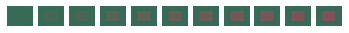

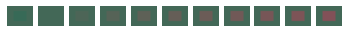

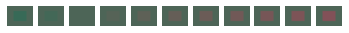

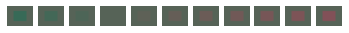

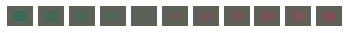

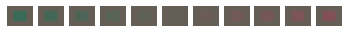

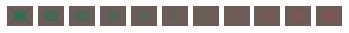

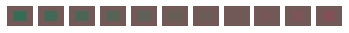

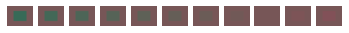

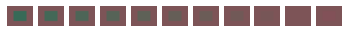

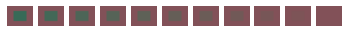

In [7]:
for bgc in rgb.T:
    fig, ax = plt.subplots(1,len(rgb.T))
    for axis, sqc in zip(ax, rgb.T):
        a = create_colored_square(img_size=img_size,
                                  square_size=square_size,
                                  square_color=sqc,
                                  bg_color=bgc)
        axis.imshow(a)
        axis.axis('off')
    plt.show()

By doing so we end up with `N` different samples of the effect (`N^2` images).

## Passing the colors through the network

In [8]:
weights_path = get_file(fname='perceptnet_rgb.h5',
                        origin='https://github.com/Jorgvt/perceptnet/releases/download/Weights/final_model_rgb.h5')

In [9]:
model = PerceptNet(kernel_initializer='ones', gdn_kernel_size=1, learnable_undersampling=False)
model.build(input_shape=(None, 384, 512, 3))
model.load_weights(weights_path)

2022-04-27 17:14:04.706274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5290 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5


We can do the processing on the fly to save memory:

In [12]:
all_readouts = np.empty(shape=(N,N))

for idx_bg, bgc in enumerate(rgb.T):
    colored_squares = np.empty(shape=(N,*img_size,3))
    ## Generate all the colored squares with a fixed bg_color
    for i, sqc in enumerate(rgb.T):
        colored_square = create_colored_square(img_size=img_size,
                                               square_size=square_size,
                                               square_color=sqc,
                                               bg_color=bgc)
        colored_squares[i] = colored_square

    ## Normalize the images
    colored_squares = (colored_squares-colored_squares.min())/(colored_squares.max()-colored_squares.min())

    ## Pass them through the model
    outputs = model.predict(colored_squares)

    ## Get the readouts as the distance to the background color
    readouts = (outputs-outputs[idx_bg])**2
    readouts = np.sqrt(np.sum(readouts.reshape(N,-1), axis=-1))
    signs = np.ones_like(readouts)
    signs[:idx_bg] = -1
    readouts = readouts*signs

    ## Store them in all_readouts
    all_readouts[idx_bg] = readouts

Plot the results:

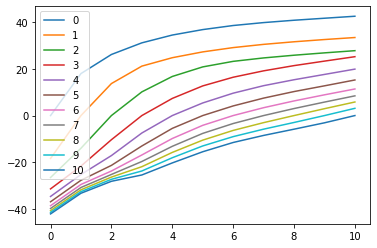

In [13]:
plt.figure()
for i, readout in enumerate(all_readouts):
    plt.plot(readout, label=i)
plt.legend()
plt.show()